Hands-on recommender systems.

In [54]:
import numpy as np
import pandas as pd
from numpy import loadtxt 
import torch
import random

torch.manual_seed(0)
random.seed(0)

#### Theory

| General <br /> Notation | Description | Python (if any) |
|:------------------------|:------------------------------------------------------------|:------------------|
| $r(i,j)$                | Scalar; = 1 if user *j* rated movie *i*, = 0 otherwise       |                  |
| $y(i,j)$                | Scalar; rating given by user *j* on movie *i* (if $r(i,j) = 1$) |              |
| $\mathbf{w}^{(j)}$      | Vector; parameters for user *j*                              |                  |
| $b^{(j)}$               | Scalar; bias parameter for user *j*                          |                  |
| $\mathbf{x}^{(i)}$      | Vector; feature ratings for movie *i*                        |                  |
| $n_u$                   | Number of users                                              | `num_users`      |
| $n_m$                   | Number of movies                                             | `num_movies`     |
| $n$                     | Number of features                                           | `num_features`   |
| $\mathbf{X}$            | Matrix of vectors $\mathbf{x}^{(i)}$                         | `X`              |
| $\mathbf{W}$            | Matrix of vectors $\mathbf{w}^{(j)}$                         | `W`              |
| $\mathbf{b}$            | Vector of bias parameters $b^{(j)}$                          | `b`              |
| $\mathbf{R}$            | Matrix of elements $r(i,j)$                                  | `R`              |


To implement the collaborative filtering learning algorithm and apply it to a dataset (i.e. movie ratings).
The goal of a collaborative filtering recommender system is to generate two vectors: For each user, a 'parameter vector' that embodies the movie tastes of a user. For each movie, a feature vector of the same size which embodies some description of the movie. The dot product of the two vectors plus the bias term should produce an estimate of the rating the user might give to that movie.

The diagram below details how these vectors are learned.

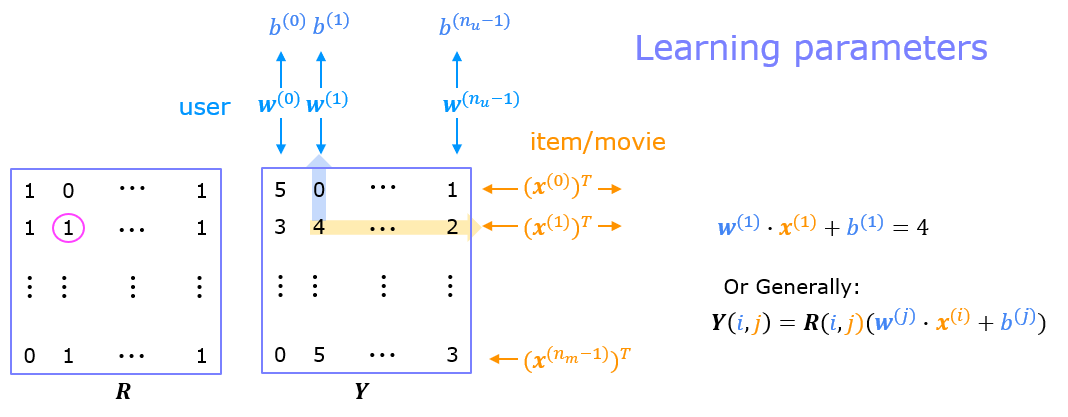

Existing ratings are provided in matrix form as shown. $Y$ contains ratings; 0.5 to 5 inclusive in 0.5 steps. 0 if the movie has not been rated. $R$ has a 1 where movies have been rated. Movies are in rows, users in columns. Each user has a parameter vector $w^{user}$ and bias. Each movie has a feature vector $x^{movie}$. These vectors are simultaneously learned by using the existing user/movie ratings as training data. One training example is shown above: $\mathbf{w}^{(1)} \cdot \mathbf{x}^{(1)} + b^{(1)} = 4$. It is worth noting that the feature vector $x^{movie}$ must satisfy all the users while the user vector $w^{user}$ must satisfy all the movies. This is the source of the name of this approach - all the users collaborate to generate the rating set. 

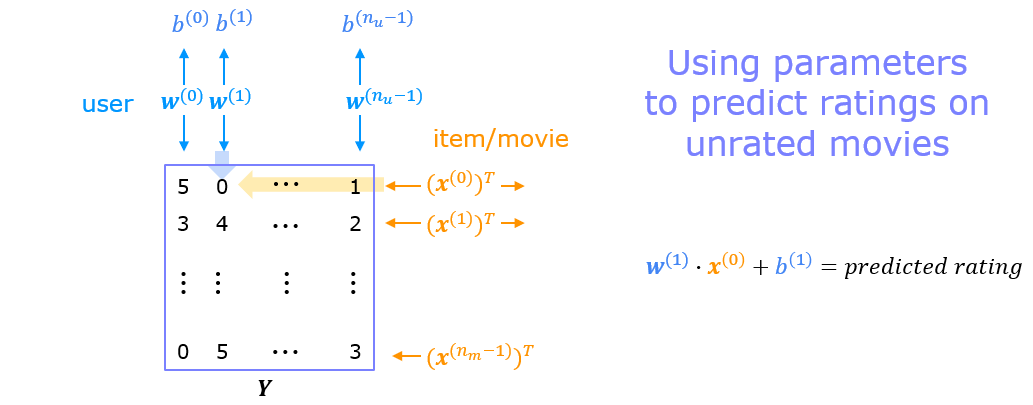

Once the feature vectors and parameters are learned, they can be used to predict how a user might rate an unrated movie. This is shown in the diagram above. The equation is an example of predicting a rating for user one on movie zero.

#### Dataset

The original dataset has  9000 movies rated by 600 users. The dataset has been reduced in size to focus on movies from the years since 2000. This dataset consists of ratings on a scale of 0.5 to 5 in 0.5 step increments. The reduced dataset has $n_u = 443$ users, and $n_m= 4778$ movies. 

Below, you will load the movie dataset into the variables $Y$ and $R$.

The matrix $Y$ (a  $n_m \times n_u$ matrix) stores the ratings $y^{(i,j)}$. The matrix $R$ is an binary-valued indicator matrix, where $R(i,j) = 1$ if user $j$ gave a rating to movie $i$, and $R(i,j)=0$ otherwise. 

Throughout this part we will also be working with the
matrices, $\mathbf{X}$, $\mathbf{W}$ and $\mathbf{b}$: 

$$\mathbf{X} = 
\begin{bmatrix}
--- (\mathbf{x}^{(0)})^T --- \\
--- (\mathbf{x}^{(1)})^T --- \\
\vdots \\
--- (\mathbf{x}^{(n_m-1)})^T --- \\
\end{bmatrix} , \quad
\mathbf{W} = 
\begin{bmatrix}
--- (\mathbf{w}^{(0)})^T --- \\
--- (\mathbf{w}^{(1)})^T --- \\
\vdots \\
--- (\mathbf{w}^{(n_u-1)})^T --- \\
\end{bmatrix},\quad
\mathbf{ b} = 
\begin{bmatrix}
 b^{(0)}  \\
 b^{(1)} \\
\vdots \\
b^{(n_u-1)} \\
\end{bmatrix}\quad
$$ 

The $i$-th row of $\mathbf{X}$ corresponds to the
feature vector $x^{(i)}$ for the $i$-th movie, and the $j$-th row of
$\mathbf{W}$ corresponds to one parameter vector $\mathbf{w}^{(j)}$, for the
$j$-th user. Both $x^{(i)}$ and $\mathbf{w}^{(j)}$ are $n$-dimensional
vectors. For the purposes of this exercise, you will use $n=10$, and
therefore, $\mathbf{x}^{(i)}$ and $\mathbf{w}^{(j)}$ have 10 elements.
Correspondingly, $\mathbf{X}$ is a
$n_m \times 10$ matrix and $\mathbf{W}$ is a $n_u \times 10$ matrix.


In [41]:
def load_precalc_params_small():

    file = open('./data/recommender/small_movies_X.csv', 'rb')
    X = loadtxt(file, delimiter = ",")

    file = open('./data/recommender/small_movies_W.csv', 'rb')
    W = loadtxt(file,delimiter = ",")

    file = open('./data/recommender/small_movies_b.csv', 'rb')
    b = loadtxt(file,delimiter = ",")
    b = b.reshape(1,-1)
    num_movies, num_features = X.shape
    num_users,_ = W.shape
    return(X, W, b, num_movies, num_features, num_users)

def load_ratings_small():
    file = open('./data/recommender/small_movies_Y.csv', 'rb')
    Y = loadtxt(file,delimiter = ",")

    file = open('./data/recommender/small_movies_R.csv', 'rb')
    R = loadtxt(file,delimiter = ",")
    return(Y,R)
    
def normalizeRatings(Y, R):
    """
    Preprocess data by subtracting mean rating for every movie (every row).
    Only include real ratings R(i,j)=1.
    [Ynorm, Ymean] = normalizeRatings(Y, R) normalized Y so that each movie
    has a rating of 0 on average. Unrated moves then have a mean rating (0)
    Returns the mean rating in Ymean.
    """
    Ymean = (np.sum(Y*R,axis=1)/(np.sum(R, axis=1)+1e-12)).reshape(-1,1)
    Ynorm = Y - np.multiply(Ymean, R) 
    return(Ynorm, Ymean)
    
def load_Movie_List_pd():
    """ returns df with and index of movies in the order they are in in the Y matrix """
    df = pd.read_csv('./data/recommender/small_movie_list.csv', header=0, index_col=0,  delimiter=',', quotechar='"')
    mlist = df["title"].to_list()
    return(mlist, df)

In [121]:
#Load data
X, W, b, num_movies, num_features, num_users = load_precalc_params_small()
Y, R = load_ratings_small()

print("Y", Y.shape, "R", R.shape)
print("X", X.shape)
print("W", W.shape)
print("b", b.shape)
print("num_features", num_features)
print("num_movies",   num_movies)
print("num_users",    num_users)

Y (4778, 443) R (4778, 443)
X (4778, 10)
W (443, 10)
b (1, 443)
num_features 10
num_movies 4778
num_users 443


In [15]:
#  From the matrix, we can compute statistics like average rating.
tsmean =  np.mean(Y[0, R[0, :].astype(bool)])
print(f"Average rating for movie 1 : {tsmean:0.3f} / 5" )

Average rating for movie 1 : 3.400 / 5


#### Collaborative Filtering: using per-item features

The collaborative filtering algorithm in the setting of movie
recommendations considers a set of $n$-dimensional parameter vectors
$\mathbf{x}^{(0)},...,\mathbf{x}^{(n_m-1)}$, $\mathbf{w}^{(0)},...,\mathbf{w}^{(n_u-1)}$ and $b^{(0)},...,b^{(n_u-1)}$, where the
model predicts the rating for movie $i$ by user $j$ as
$y^{(i,j)} = \mathbf{w}^{(j)}\cdot \mathbf{x}^{(i)} + b^{(j)}$ . Given a dataset that consists of
a set of ratings produced by some users on some movies, you wish to
learn the parameter vectors $\mathbf{x}^{(0)},...,\mathbf{x}^{(n_m-1)},
\mathbf{w}^{(0)},...,\mathbf{w}^{(n_u-1)}$  and $b^{(0)},...,b^{(n_u-1)}$ that produce the best fit (minimizes
the squared error).


The collaborative filtering cost function is given by
$$J({\mathbf{x}^{(0)},...,\mathbf{x}^{(n_m-1)},\mathbf{w}^{(0)},b^{(0)},...,\mathbf{w}^{(n_u-1)},b^{(n_u-1)}})= \left[ \frac{1}{2}\sum_{(i,j):r(i,j)=1}(\mathbf{w}^{(j)} \cdot \mathbf{x}^{(i)} + b^{(j)} - y^{(i,j)})^2 \right]
+ \underbrace{\left[
\frac{\lambda}{2}
\sum_{j=0}^{n_u-1}\sum_{k=0}^{n-1}(\mathbf{w}^{(j)}_k)^2
+ \frac{\lambda}{2}\sum_{i=0}^{n_m-1}\sum_{k=0}^{n-1}(\mathbf{x}_k^{(i)})^2
\right]}_{regularization}
\tag{1}$$
The first summation in (1) is "for all $i$, $j$ where $r(i,j)$ equals $1$" and could be written:

$$
= \left[ \frac{1}{2}\sum_{j=0}^{n_u-1} \sum_{i=0}^{n_m-1}r(i,j)*(\mathbf{w}^{(j)} \cdot \mathbf{x}^{(i)} + b^{(j)} - y^{(i,j)})^2 \right]
+\text{regularization}
$$


In [119]:
def cofi_cost_func(X, W, b, Y, R, lambda_):
    """
    Returns the cost for the content-based filtering
    Args:
      X (ndarray (num_movies,num_features)): matrix of item features
      W (ndarray (num_users,num_features)) : matrix of user parameters
      b (ndarray (1, num_users)            : vector of user parameters
      Y (ndarray (num_movies,num_users)    : matrix of user ratings of movies
      R (ndarray (num_movies,num_users)    : matrix, where R(i, j) = 1 if the i-th movies was rated by the j-th user
      lambda_ (float): regularization parameter
    Returns:
      J (float) : Cost
    """
    nm, nu = Y.shape
    J = 0
    b = b.reshape(-1)  # Ensure b is a 1D vector

    for j in range(nu):
        for i in range(nm):
            if R[i, j] == 1:
                y_pred = W[j] @ X[i] + b[j]  # All are scalars now
                J += (y_pred - Y[i, j]) ** 2

    J *= 0.5

    # Add regularization
    J += (lambda_ / 2) * (np.sum(W**2) + np.sum(X**2))

    return J

In [122]:
# Reduce the data set size so that this runs faster
num_users_r = 4
num_movies_r = 5 
num_features_r = 3

X_r = X[:num_movies_r, :num_features_r]
W_r = W[:num_users_r,  :num_features_r]
b_r = b[0, :num_users_r].reshape(1,-1)
Y_r = Y[:num_movies_r, :num_users_r]
R_r = R[:num_movies_r, :num_users_r]

# Evaluate cost function
J = cofi_cost_func(X_r, W_r, b_r, Y_r, R_r, 0);
print(f"Cost: {J:0.2f}")

# Evaluate cost function with regularization 
J = cofi_cost_func(X_r, W_r, b_r, Y_r, R_r, 1.5);
print(f"Cost (with regularization): {J:0.2f}")

Cost: 13.67
Cost (with regularization): 28.09


In [123]:
# Another vectorized implementation that will be much faster
def cofi_cost_func_v(X, W, b, Y, R, lambda_):
    """
    Fully vectorized collaborative filtering cost function using PyTorch.
    
    Args:
      X (Tensor): (num_movies, num_features)
      W (Tensor): (num_users, num_features)
      b (Tensor): (1, num_users)
      Y (Tensor): (num_movies, num_users)
      R (Tensor): same shape as Y. 1 if rated, 0 otherwise.
      lambda_ (float): regularization parameter
      
    Returns:
      J (Tensor): scalar cost
    """
    pred = X @ W.T + b  # shape: (num_movies, num_users)
    
    error = (pred - Y) * R
    J = 0.5 * torch.sum(error ** 2)
    J += (lambda_ / 2) * (torch.sum(X ** 2) + torch.sum(W ** 2))
    return J

# Ensure all inputs are torch tensors before calling
X_r = torch.tensor(X_r, dtype=torch.float64)
W_r = torch.tensor(W_r, dtype=torch.float64)
b_r = torch.tensor(b_r, dtype=torch.float64)
Y_r = torch.tensor(Y_r, dtype=torch.float64)
R_r = torch.tensor(R_r, dtype=torch.float64)

J = cofi_cost_func_v(X_r, W_r, b_r, Y_r, R_r, 0)
print(f"Cost: {J.item():.2f}")

J = cofi_cost_func_v(X_r, W_r, b_r, Y_r, R_r, 1.5)
print(f"Cost (with regularization): {J.item():.2f}")

Cost: 13.67
Cost (with regularization): 28.09


Training the algorithm on a dummy dataset (i.e. to make movie recommendations).

In [35]:
movieList, movieList_df = load_Movie_List_pd()

In [36]:
movieList_df

,mean rating,number of ratings,title
0,3.400000,5,"Yards, The (2000)"
1,3.250000,6,Next Friday (2000)
2,2.000000,4,Supernova (2000)
3,2.000000,4,Down to You (2000)
4,2.672414,29,Scream 3 (2000)
...,...,...,...
4773,3.500000,1,Jon Stewart Has Left the Building (2015)
4774,4.000000,1,Black Butler: Book of the Atlantic (2017)
4775,3.500000,1,No Game No Life: Zero (2017)
4776,3.500000,1,Flint (2017)


In [38]:
my_ratings = np.zeros(num_movies)          #  Initialize my ratings

In [37]:
movieList_df.iloc[2700]

# Check the file small_movie_list.csv for id of each movie in our dataset
# For example, Toy Story 3 (2010) has ID 2700, so to rate it "5", you can set
my_ratings[2700] = 5 

mean rating                    4.109091
number of ratings                    55
title                Toy Story 3 (2010)
Name: 2700, dtype: object

In [39]:
# Or suppose you did not enjoy Persuasion (2007), you can set
my_ratings[2609] = 2;

# We have selected a few movies we liked / did not like and the ratings we
# gave are as follows:
my_ratings[929]  = 5   # Lord of the Rings: The Return of the King, The
my_ratings[246]  = 5   # Shrek (2001)
my_ratings[2716] = 3   # Inception
my_ratings[1150] = 5   # Incredibles, The (2004)
my_ratings[382]  = 2   # Amelie (Fabuleux destin d'Amélie Poulain, Le)
my_ratings[366]  = 5   # Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)
my_ratings[622]  = 5   # Harry Potter and the Chamber of Secrets (2002)
my_ratings[988]  = 3   # Eternal Sunshine of the Spotless Mind (2004)
my_ratings[2925] = 1   # Louis Theroux: Law & Disorder (2008)
my_ratings[2937] = 1   # Nothing to Declare (Rien à déclarer)
my_ratings[793]  = 5   # Pirates of the Caribbean: The Curse of the Black Pearl (2003)
my_rated = [i for i in range(len(my_ratings)) if my_ratings[i] > 0]

print('\nNew user ratings:\n')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0 :
        print(f'Rated {my_ratings[i]} for  {movieList_df.loc[i,"title"]}');


New user ratings:

Rated 5.0 for  Shrek (2001)
Rated 5.0 for  Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)
Rated 2.0 for  Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)
Rated 5.0 for  Harry Potter and the Chamber of Secrets (2002)
Rated 5.0 for  Pirates of the Caribbean: The Curse of the Black Pearl (2003)
Rated 5.0 for  Lord of the Rings: The Return of the King, The (2003)
Rated 3.0 for  Eternal Sunshine of the Spotless Mind (2004)
Rated 5.0 for  Incredibles, The (2004)
Rated 2.0 for  Persuasion (2007)
Rated 3.0 for  Inception (2010)
Rated 1.0 for  Louis Theroux: Law & Disorder (2008)
Rated 1.0 for  Nothing to Declare (Rien à déclarer) (2010)


Now, let's add these reviews to $Y$ and $R$ and normalize the ratings.

In [127]:
# Reload ratings
Y, R = load_ratings_small()

# Add new user ratings to Y 
Y = np.c_[my_ratings, Y]

# Add new user indicator matrix to R
R = np.c_[(my_ratings != 0).astype(int), R]

# Normalize the Dataset
Ynorm, Ymean = normalizeRatings(Y, R)

Let's prepare to train the model. Initialize the parameters and select the Adam optimizer.

In [128]:
#  Useful Values
num_movies, num_users = Y.shape
num_features = 100

In [129]:
# Initialize parameters
W = torch.nn.Parameter(torch.randn(num_users,  num_features, dtype=torch.float64))
X = torch.nn.Parameter(torch.randn(num_movies, num_features, dtype=torch.float64))
b = torch.nn.Parameter(torch.randn(1,          num_users,    dtype=torch.float64))

In [130]:
W

Parameter containing:
tensor([[-1.0648,  1.4594, -1.0583,  ...,  0.5140,  2.6645,  1.7243],
        [-0.4528,  1.6240,  1.2469,  ...,  0.3070,  0.0505, -2.3205],
        [-0.2940,  0.1260, -0.3263,  ..., -1.0635, -0.7597,  0.8097],
        ...,
        [-1.0409, -0.0183,  0.1860,  ..., -0.4540, -0.4101,  0.0234],
        [-0.2243, -0.0392,  1.5762,  ...,  0.2261, -0.7461, -0.5159],
        [-1.6716,  1.8397, -1.0546,  ...,  0.0598,  2.2042, -1.6242]],
       dtype=torch.float64, requires_grad=True)

In [131]:
# Define optimizer
optimizer = torch.optim.Adam([X, W, b], lr=1e-1)

In [132]:
# Converting some variables to torch tensor
Ynorm_ = torch.tensor(Ynorm, dtype=torch.float64)
R_ = torch.tensor(R, dtype=torch.float64)

Let's now train the collaborative filtering model. This will learn the parameters $\mathbf{X}$, $\mathbf{W}$, and $\mathbf{b}$. 

- repeat until convergence:
    - compute forward pass
    - compute the derivatives of the loss relative to parameters
    - update the parameters using the learning rate and the computed derivatives 

In [133]:
# Training loop
iterations = 200
lambda_ = 1

for iter in range(iterations):
    optimizer.zero_grad() # reset gradients

    # Forward pass and cost computation
    cost_value = cofi_cost_func_v(X, W, b, Ynorm_, R_, lambda_)

    # Backward pass (compute gradients)
    cost_value.backward()

    # Gradient update
    optimizer.step()

    # Logging
    if iter % 20 == 0:
        print(f"Training loss at iteration {iter}: {cost_value.item():.1f}")

Training loss at iteration 0: 2254488.6
Training loss at iteration 20: 131178.1
Training loss at iteration 40: 49465.4
Training loss at iteration 60: 23403.2
Training loss at iteration 80: 12979.5
Training loss at iteration 100: 8095.6
Training loss at iteration 120: 5547.5
Training loss at iteration 140: 4126.8
Training loss at iteration 160: 3298.3
Training loss at iteration 180: 2798.0


<b>Recommendations</b>

Below, we compute the ratings for all the movies and users and display the movies that are recommended. These are based on the movies and ratings entered as `my_ratings[]` above. To predict the rating of movie $i$ for user $j$, we compute $\mathbf{w}^{(j)} \cdot \mathbf{x}^{(i)} + b^{(j)}$. This can be computed for all ratings using matrix multiplication.

In [134]:
Ymean_ = torch.tensor(Ymean, dtype=torch.float64)

In [140]:
# Make a prediction using trained weights and biases
# p = np.matmul(X.numpy(), np.transpose(W.numpy())) + b.numpy()
p = X @ W.T + b

#restore the mean
pm = p + Ymean_

my_predictions = pm[:,0]

# sort predictions
ix = torch.argsort(my_predictions, descending=True)

for i in range(17):
    j = ix[i]
    if j not in my_rated:
        print(f'Predicting rating {my_predictions[j]:0.2f} for movie {movieList[j]}')

print('\n\nOriginal vs Predicted ratings:\n')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print(f'Original {my_ratings[i]}, Predicted {my_predictions[i]:0.2f} for {movieList[i]}')

Predicting rating 4.52 for movie Eva (2011)
Predicting rating 4.50 for movie Colourful (Karafuru) (2010)
Predicting rating 4.49 for movie Jump In! (2007)
Predicting rating 4.49 for movie Laggies (2014)
Predicting rating 4.49 for movie Delirium (2014)
Predicting rating 4.48 for movie One I Love, The (2014)
Predicting rating 4.48 for movie I'm the One That I Want (2000)
Predicting rating 4.47 for movie Into the Abyss (2011)
Predicting rating 4.47 for movie Eichmann (2007)
Predicting rating 4.47 for movie Battle Royale 2: Requiem (Batoru rowaiaru II: Chinkonka) (2003)
Predicting rating 4.46 for movie PK (2014)


Original vs Predicted ratings:

Original 5.0, Predicted 4.88 for Shrek (2001)
Original 5.0, Predicted 4.85 for Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)
Original 2.0, Predicted 2.18 for Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)
Original 5.0, Predicted 4.85 for Harry Potter and the Chamber of Secrets (2002)
Original 5.

In practice, additional information can be utilized to enhance our predictions. Above, the predicted ratings for the first few hundred movies lie in a small range. We can augment the above by selecting from those top movies, movies that have high average ratings and movies with more than 20 ratings. This section uses a [Pandas](https://pandas.pydata.org/) data frame which has many handy sorting features.

In [142]:
filter=(movieList_df["number of ratings"] > 20)
movieList_df["pred"] = my_predictions.detach().numpy()
movieList_df = movieList_df.reindex(columns=["pred", "mean rating", "number of ratings", "title"])
movieList_df.loc[ix[:300]].loc[filter].sort_values("mean rating", ascending=False)

,pred,mean rating,number of ratings,title
155,3.983261,4.155914,93,Snatch (2000)
676,4.118894,4.146667,75,City of God (Cidade de Deus) (2002)
929,4.859272,4.118919,185,"Lord of the Rings: The Return of the King, The..."
393,4.333173,4.106061,198,"Lord of the Rings: The Fellowship of the Ring,..."
3714,4.040965,4.050847,59,Guardians of the Galaxy (2014)
653,4.372271,4.021277,188,"Lord of the Rings: The Two Towers, The (2002)"
2804,4.259823,3.989362,47,Harry Potter and the Deathly Hallows: Part 1 (...
3283,4.083179,3.982143,28,Argo (2012)
51,4.203349,3.938235,170,Gladiator (2000)
246,4.876506,3.867647,170,Shrek (2001)
